# Polynya/lead detection

In [1]:
import numpy as np 
import cartopy
import cartopy.crs as ccrs
import matplotlib
matplotlib.interactive(True)
import cmocean
from netCDF4 import Dataset
import glob
import matplotlib.pyplot as plt
import datetime 
from datetime import date 
import mpl_toolkits.basemap as bm
import matplotlib.animation as animation
import numpy.ma as ma
import matplotlib.cm as cm
from matplotlib.patches import Polygon
from scipy import signal, stats
import time
from scipy.interpolate import interp1d
from mpl_toolkits.axes_grid1 import make_axes_locatable
import warnings; warnings.simplefilter('ignore')
import seaborn as sns
from functions import trend, load_ice, plot_cartopy
from matplotlib import gridspec

# %matplotlib notebook

In [2]:
path = '/extra-space1/data/tikoralukupload/cis-weekly/nc/'
region = 'EC'

# Projection for mapping
rot = ccrs.RotatedPole(pole_latitude=55,pole_longitude=150)

# Read in data
nc = Dataset(path + region + '.nc', 'r')
lon = nc.variables['longitude'][:1200,:1500]
lat = nc.variables['latitude'][:1200,:1500]
juld = nc.variables['juld'][:]
land = nc.variables['land'][:1200,:1500]
E_CT = nc.variables['E_CT'][:][:,:1200,:1500]       

CT = np.nan*np.ones(E_CT.shape)
CT[E_CT==1] = 10
CT[E_CT==2] = 20
CT[E_CT==3] = 30
CT[E_CT==4] = 40
CT[E_CT==5] = 50
CT[E_CT==6] = 60
CT[E_CT==7] = 70
CT[E_CT==8] = 80
CT[E_CT==9] = 90
CT[E_CT==10] = 95
CT[E_CT==11] = 100

# Date time information
d0ord = date(1950,1,1).toordinal()
dt_ordinal = d0ord + juld
dates = [date.fromordinal(dt_ordinal[tt]) for tt in range(len(juld))]
months = [dates[tt].month for tt in range(len(juld))]
years = [dates[tt].year for tt in range(len(juld))]
months_unique = np.unique(months)
years_unique = np.unique(years)

In [3]:
def plot_cartopy(ax, lon, lat):
    '''
    Set up the cartopy map with projection rotated so that Labrador coast is vertical. Input is the ax handle. 
    '''
    #Declare the land and ocean parameters
    LAND_highres = cartopy.feature.NaturalEarthFeature('physical', 'land', '10m',
    edgecolor='black',
    facecolor=('silver'),
    linewidth=1)
    OCEAN_highres = cartopy.feature.NaturalEarthFeature('physical', 'ocean', '10m',
    facecolor='dimgrey')

    #Declare the lat and lon boundaries for the map and data
    domain = [99, 99, -99, -99]
    domain[0] = np.min(lat) # South
    domain[1] = np.min(lon) # West
    domain[2] = np.max(lat) # North
    domain[3] = np.max(lon) # East
    domain = list(np.array(domain) + np.array([+17, +21, -9, -20]))
#     domain = [53.58105923668295, -61.30979545701268, 61.589404038199575, -56.47452933956656]
    # domain = [55, -61.30979545701268, 59, -61]

    aoi_map = [domain[0], domain[2], domain[1], domain[3]]
    # Rotation for vertical coast
    rot = ccrs.RotatedPole(pole_latitude=55,pole_longitude=150)

#     # Plot results
#     transform = rot.transform_points(rot,lon,lat)
#     x_n = transform[...,0]
#     y_n = transform[...,1]

    ax.add_feature(LAND_highres,zorder=2)
    ax.add_feature(OCEAN_highres,zorder=3)
    ax.set_extent([aoi_map[2], aoi_map[3], aoi_map[0], aoi_map[1]])
    ax.coastlines(resolution='10m',linewidth=0.35,zorder=3)
    

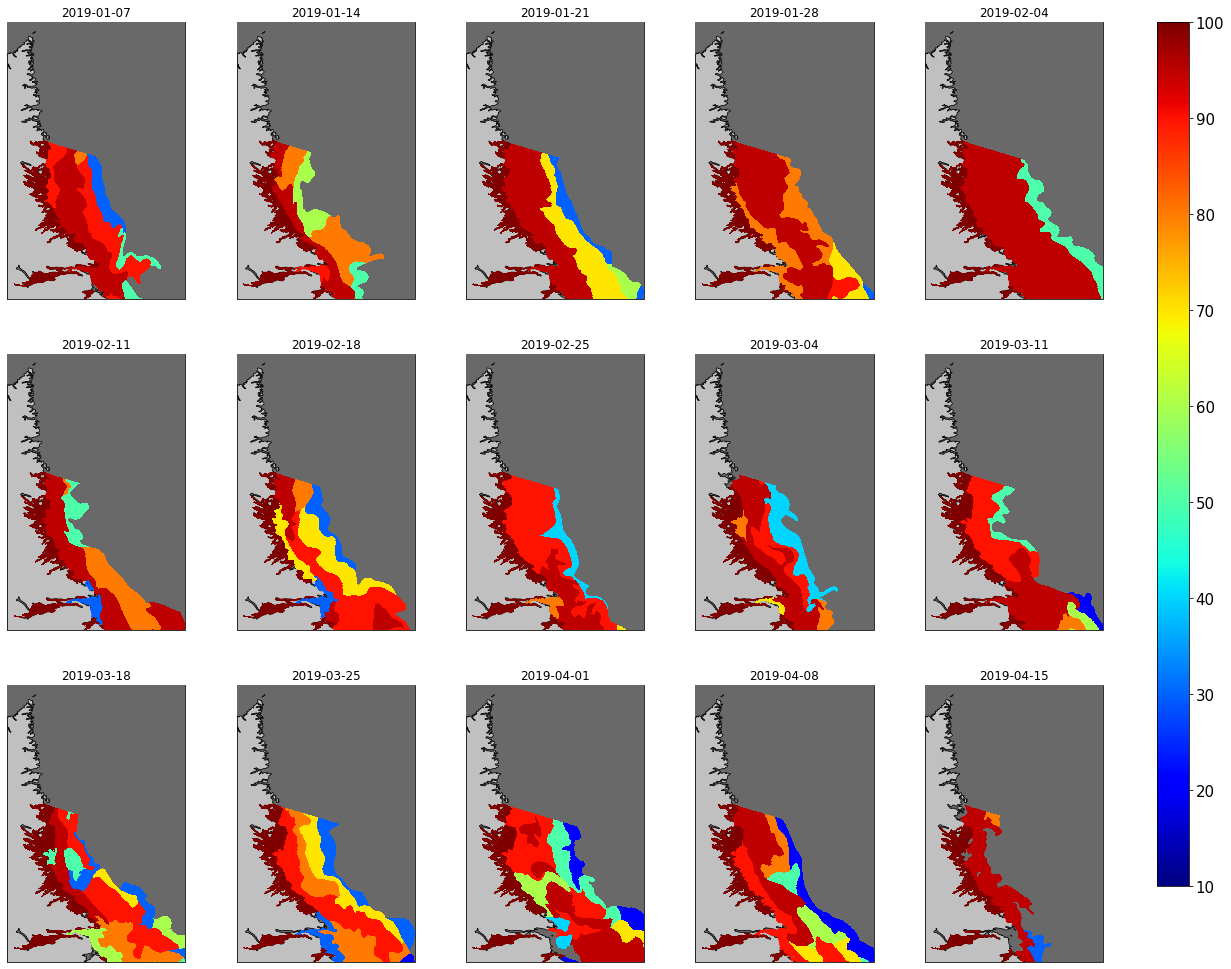

In [18]:
# Plot start of 2019
yr = years_unique[-2]
mon = 3
which = (years == yr) #* (np.array(months) == mon)
if np.sum(which) >= 1:
    # Save all observational days of the month
    tt = np.where(which)[0]


fig = plt.figure(figsize=(22,15))
cnt=1
for i in tt:
    ax = fig.add_subplot(3,5,cnt,projection=rot)
    plot_cartopy(ax,lon,lat)
    im = plt.pcolormesh(lon,lat,CT[i,:,:],vmin=10,vmax=100,cmap='jet',transform=ccrs.PlateCarree(),zorder=4)
    plt.title(dates[i])
    cnt+=1
    if cnt==16:
        break
        
fig.subplots_adjust(bottom=0.03, top=0.9, left=0.1, right=0.8,
                    wspace=0.2, hspace=0.2)
cb_ax = fig.add_axes([0.83, 0.1, 0.02, 0.8])
cbar = fig.colorbar(im, cax=cb_ax)
cbar.ax.tick_params(labelsize=15)
    
plt.tight_layout()


METHOD 1: Find regions that are touching N number of points that have a concentration greater than 20%. 

In [172]:
m = np.shape(CT)[1]
n = np.shape(CT)[2]
k = 1586
polynya_i = []
polynya_j = []

for i in range(n):
    polynya_ii = []
    polynya_jj = []
    # Check for any non-nans
    not_nans = np.where(np.isnan(CT[k,:,i])==False)[0]
    if len(not_nans) > 2:
        for j in range(len(not_nans)-1):
            if abs(CT[k,not_nans[j],i] - CT[k,not_nans[j+1],i]) > 10:
                polynya_jj.append(j)
                polynya_ii.append(i)
                
    polynya_i.append(polynya_ii)
    polynya_j.append(polynya_jj)

# Try OpenCV

In [5]:
# convert the image to grayscale format
import cv2
k = 1586

# Already grayscale
image = CT[k,:,:].astype(np.uint8)

# img = np.array(float_img*255).astype('uint8')
# img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# detect the contours on the binary image using cv2.CHAIN_APPROX_NONE

contours, hierarchy = cv2.findContours(image=image, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
# draw contours on the original image

In [6]:
image_copy = image.copy()
cv2.drawContours(image=image_copy, contours=contours, contourIdx=-1, color=(0, 255, 0), thickness=2, lineType=cv2.LINE_AA)

array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ..., 43,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint8)

In [14]:
# apply binary thresholding
ret, thresh = cv2.threshold(image, 150, 255, cv2.THRESH_BINARY)
# visualize the binary image
# cv2.imshow('Binary image', thresh)
# cv2.waitKey(0)
# cv2.imwrite('image_thres1.jpg', thresh)
# cv2.destroyAllWindows()

In [ ]:
# see the results

plt.imshow('None approximation', image_copy)
cv2.waitKey(0)
cv2.imwrite('contours_none_image1.jpg', image_copy)
cv2.destroyAllWindows()

In [11]:
np.min(image_copy)

0

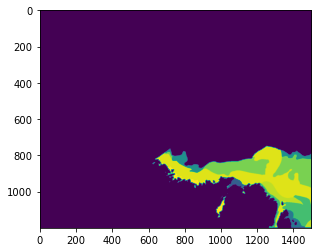

In [12]:
plt.imshow(image_copy)

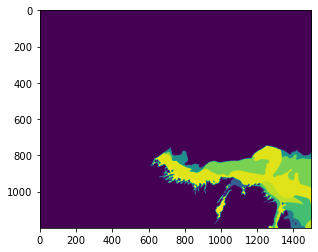

In [13]:
plt.imshow(image)